# TensorFlow / Keras cheat sheet

Originally published in https://gitlab.com/Winston-90/tf_cheat_sheet


<div style="border: 5px ridge; padding:5%"> 
<h1>Table of Contents</h1>
<hr style="border:2px solid black" />

<h3>Preamble</h3>
<ul>
    <li><h4><a href="#Imports">Imports</a></h4></li>
    <li><h4><a href="#Helping">Helping variables</a></h4></li>
    <li><h4><a href="#Get_data">Get time series data</a></h4></li>
    <li><h4><a href="#DataGenerator">ImageDataGenerator</a></h4></li>
    <li><h4><a href="#Tokenize">Tokenize and pad sentences</a></h4></li>
</ul>
    
<h3><a href="#Sequential">1. Typical Neural Network Architectures using Sequential API</a></h3>
<h3><a href="#Functional">2. More Complex Neural Network Architecture using Functional API</a></h3>
<h3><a href="#Compile">3. Compile the model</a></h3>
<h3><a href="#Train">4. Train the model</a></h3>
<h3><a href="#Explore">5. Explore learning curves</a></h3>
<h3><a href="#Evaluate">6. Evaluate the model</a></h3>
<h3><a href="#Save">7. Save and load the model</a></h3>
</div>

<h3><a id="Imports">Imports</a></h3>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# special imports for CV and NLP
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print(tf.__version__)
# 2.7.0

2.7.0


<h3><a id="Helping">Helping variables</a></h3>

In [2]:
NUM_EPOCHS = 2
BATCH_SIZE = 32
SEED = 1

IMG_HEIGHT = 300
IMG_WIDTH = 300
CHANNELS = 3

num_inputs = 1
num_classes = 3

X_train = np.array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 9.0, 10.0], dtype=float)
y_train = np.array([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.5, 5.0, 5.5], dtype=float)

X_test = np.array([7.0, 11.0], dtype=float)
y_test = np.array([4.0, 6.0], dtype=float)

<h3><a id="Get_data">Get time series data</a></h3>

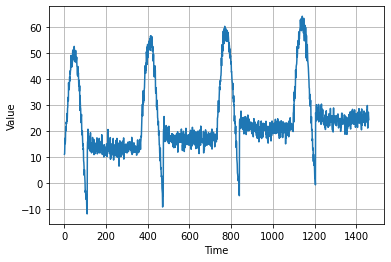

In [3]:
# get some time series data
# the original code is taken from:
# https://github.com/https-deeplearning-ai/tensorflow-1-public

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    """ Just an arbitrary pattern """
    return np.where(season_time < 0.3,
                    np.sin(season_time * 4 * np.pi),
                    1 / np.exp(7 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """ Repeats the same pattern at each period """
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
baseline = 10
amplitude = 40
slope = 0.01
noise_level = 2

# Create the series
series = baseline + trend(time, slope) + \
    seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 3000
time_train = time[:split_time]
series_train = series[:split_time]

WINDOW_SIZE = 20
SHUFFLE_BUFFER_SIZE = 1000

plot_series(time, series)

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(
        lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(series_train,
                           WINDOW_SIZE,
                           BATCH_SIZE,
                           SHUFFLE_BUFFER_SIZE)

<h3><a id="DataGenerator">ImageDataGenerator</a></h3>

Official documentation - https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [5]:
# extract Horse or Human datasets for computer vision (ImageDataGenerator)
# downloaded from: https://laurencemoroney.com/datasets.html

import os
import zipfile
import shutil

# Get the Horse or Human dataset
path_horse_or_human = "data/horse-or-human.zip"
# Get the Horse or Human Validation dataset
path_validation_horse_or_human = "data/validation-horse-or-human.zip"

local_zip = path_horse_or_human
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('data/horse-or-human')
zip_ref.close()

local_zip = path_validation_horse_or_human
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('data/validation-horse-or-human')
zip_ref.close()

train_dir = 'data/horse-or-human'
validation_dir = 'data/validation-horse-or-human'

In [6]:
# augmented ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# default ImageDataGenerator without augmentation
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'  # 'categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'  # 'categorical'
)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [7]:
# Another option is not to specify the validation set explicitly,
# but to entrust the split to ImageDataGenerator
# In this case, be sure that the seed parameter is the same
# for both sets, otherwise the sets may overlap

train_datagen = ImageDataGenerator(rescale=1./255,
                                   # set validation split ratio
                                   validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',  # 'categorical'
    subset='training',  # set as training data
    seed=SEED)

validation_generator = train_datagen.flow_from_directory(
    train_dir,  # the same directory
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',  # 'categorical'
    subset='validation',  # set as validation data
    seed=SEED)

Found 822 images belonging to 2 classes.
Found 205 images belonging to 2 classes.


<h3><a id="Tokenize">Tokenize and pad sentences</a></h3>

- Official documentation for Tokenizer - https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
- Official documentation for pad_sequences method - https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences

In [8]:
# extract BBC news dataset for NLP
# downloaded from: https://www.kaggle.com/yufengdev/bbc-fulltext-and-category

import pandas as pd

df = pd.read_csv('data/bbc-text.csv')

sentences = df['text'].to_numpy()
labels = df['category']
dataset_size = len(sentences)
training_size = int(len(sentences) * 0.8)

training_sentences = sentences[:training_size]
training_labels_text = labels[:training_size]
validation_sentences = sentences[training_size:]
validation_labels_text = labels[training_size:]

label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(training_labels_text)

training_labels = np.array(
    label_tokenizer.texts_to_sequences(training_labels_text))
validation_labels = np.array(
    label_tokenizer.texts_to_sequences(validation_labels_text))

num_classes_nlp = len(np.unique(training_labels))

print('BBC news dataset dowloaded from https://www.kaggle.com/yufengdev/bbc-fulltext-and-category')
print(f'Dataset size: {dataset_size}')
print(f'Train set size: {len(training_sentences)}')
print(f'Validation set size: {len(validation_sentences)}')
print('')
print(f'First training sentence: {training_sentences[3]}')
print(f'First training label: {training_labels[3]}')

BBC news dataset dowloaded from https://www.kaggle.com/yufengdev/bbc-fulltext-and-category
Dataset size: 2225
Train set size: 1780
Validation set size: 445

First training sentence: yeading face newcastle in fa cup premiership side newcastle united face a trip to ryman premier league leaders yeading in the fa cup third round.  the game - arguably the highlight of the draw - is a potential money-spinner for non-league yeading  who beat slough in the second round. conference side exeter city  who knocked out doncaster on saturday  will travel to old trafford to meet holders manchester united in january. arsenal were drawn at home to stoke and chelsea will play host to scunthorpe. the only other non-league side in the draw are hinckley united  who held brentford to a goalless draw on sunday. they will meet league one leaders luton if they win their replay against martin allen s team at griffin park.  a number of premiership teams face difficult away games against championship sides on the

In [9]:
# default parameters
vocab_size = 1000
embedding_dim = 32
max_length = 100
trunc_type = "post"
padding_type = "post"
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences,
                                maxlen=max_length,
                                padding=padding_type,
                                truncating=trunc_type)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences,
                                  maxlen=max_length,
                                  padding=padding_type)

<h2><a id="Sequential">1. Typical Neural Network Architectures using Sequential API</a></h2>

Official documentation - https://www.tensorflow.org/guide/keras/sequential_model

In [10]:
# DNN
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu',
                          input_shape=(num_inputs, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1, activation='relu'),  # regression
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                128       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,241
Trainable params: 2,241
Non-trainable params: 0
_________________________________________________________________


In [11]:
# CNN
model = tf.keras.models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu',
                  input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')  # binary classification
    # multi-class classification
    # layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 128)     

In [12]:
# RNN for NLP
model = tf.keras.Sequential([
    layers.Embedding(vocab_size,
                     embedding_dim,
                     input_length=max_length),
    layers.Bidirectional(layers.LSTM(32, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(16)),
    layers.Dropout(0.3),
    layers.Dense(16, activation='relu'),
    layers.Dense(6, activation='softmax')  # multiclass classification
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           32000     
                                                                 
 bidirectional (Bidirectiona  (None, 100, 64)          16640     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 16)                528       
                                                                 
 dense_6 (Dense)             (None, 6)                

In [13]:
# RNN for time series
model = tf.keras.Sequential([
    layers.Conv1D(filters=128, kernel_size=7,
                  strides=1, padding="causal",
                  activation="relu",
                  input_shape=(WINDOW_SIZE, 1)),
    # univariate time series - predict a value based on
    # 'WINDOW_SIZE' previous steps for 1 feature

    layers.LSTM(32, return_sequences=True),
    layers.LSTM(16, return_sequences=True),
    layers.Dense(16, activation="relu"),
    layers.Dense(1)  # predict one value
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 128)           1024      
                                                                 
 lstm_2 (LSTM)               (None, 20, 32)            20608     
                                                                 
 lstm_3 (LSTM)               (None, 20, 16)            3136      
                                                                 
 dense_7 (Dense)             (None, 20, 16)            272       
                                                                 
 dense_8 (Dense)             (None, 20, 1)             17        
                                                                 
Total params: 25,057
Trainable params: 25,057
Non-trainable params: 0
_________________________________________________________________


<h2><a id="Functional">2. More Complex Neural Network Architecture using Functional API</a></h2>

Official documentation - https://www.tensorflow.org/guide/keras/functional

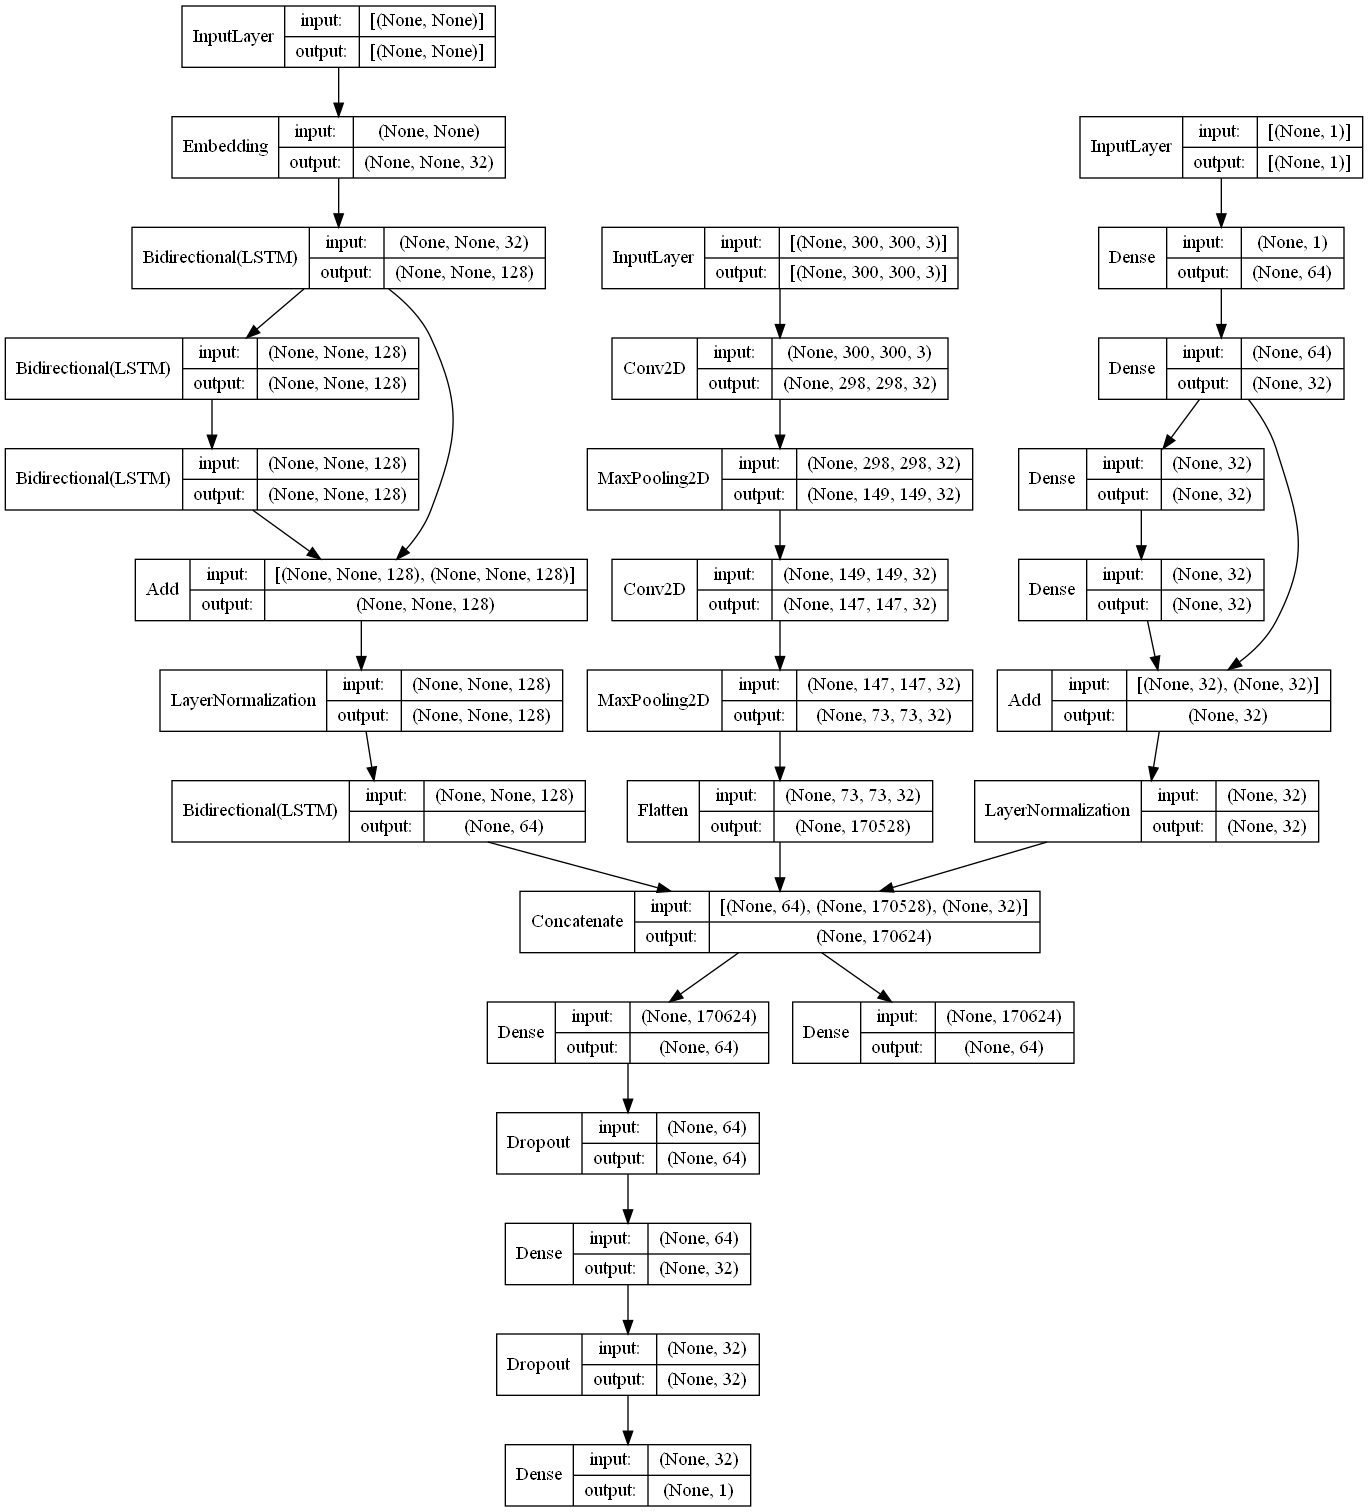

In [14]:
# variable-size input for text
text_input = tf.keras.Input(shape=(None,), name="text_input")

# input for images IMG_HEIGHT x IMG_WEGTH x CHANNELS
image_input = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS),
                             name="image_input")

# input for numbers ('num_inputs' variables)
numbers_input = tf.keras.Input(shape=(num_inputs,), name="numbers_input")

# processing text
text_features = layers.Embedding(max_length,
                                 embedding_dim,
                                 input_length=max_length)(text_input)
text_features_buf = layers.Bidirectional(
    layers.LSTM(64, return_sequences=True))(text_features)
text_features = layers.Bidirectional(layers.LSTM(
    64, return_sequences=True))(text_features_buf)
text_features = layers.Bidirectional(
    layers.LSTM(64, return_sequences=True))(text_features)
text_features = layers.Add()([text_features, text_features_buf])
text_features = layers.LayerNormalization()(text_features)
text_features = layers.Bidirectional(layers.LSTM(32))(text_features)

# processing images
image_features = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
image_features = layers.MaxPooling2D(2, 2)(image_features)
image_features = layers.Conv2D(32, (3, 3), activation='relu')(image_features)
image_features = layers.MaxPooling2D(2, 2)(image_features)
image_features = layers.Flatten()(image_features)

# processing numbers
numbers_features = layers.Dense(units=64, activation='relu')(numbers_input)
numbers_features_buf = layers.Dense(
    units=32, activation='relu')(numbers_features)
numbers_features = layers.Dense(
    units=32, activation='relu')(numbers_features_buf)
numbers_features = layers.Dense(units=32, activation='relu')(numbers_features)
numbers_features = layers.Add()([numbers_features, numbers_features_buf])
numbers_features = layers.LayerNormalization()(numbers_features)

# merge all available features into a single large vector
concat = layers.concatenate([text_features,
                             image_features,
                             numbers_features])

intermediate_output = tf.keras.layers.Dense(64, activation='relu')(concat)

# final part of the model
dense_1 = layers.Dense(64, activation='relu')(concat)
dropout_1 = layers.Dropout(0.2)(dense_1)
dense_2 = layers.Dense(32, activation='relu')(dropout_1)
dropout_2 = layers.Dropout(0.2)(dense_2)
output = layers.Dense(1, activation='relu')(dropout_2)

model = tf.keras.Model(inputs=[text_input, image_input, numbers_input],
                       outputs=[intermediate_output, output])


from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True,
           show_layer_names=False, to_file='data/img/model.png')

<h2><a id="Compile">3. Compile the model</a></h2>

Official documentation - https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile
- See all optimizers - https://keras.io/api/optimizers/#available-optimizers
- See all losses - https://keras.io/api/losses/
- See all metrics - https://keras.io/api/metrics/

In [15]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Typical optimizers:
# - tf.keras.optimizers.Adam(learning_rate=0.001)
# - tf.keras.optimizers.RMSprop(learning_rate=0.001)

# Typical classification losses:
# - tf.keras.losses.BinaryCrossentropy()
# - tf.keras.losses.CategoricalCrossentropy()        # y - one-hot
# - tf.keras.losses.SparseCategoricalCrossentropy()  # y - integer

# Typical regression losses:
# - tf.keras.losses.MeanSquaredError()
# - tf.keras.losses.MeanAbsoluteError()
# - tf.keras.losses.Huber()

# Typical metrics
# - ['accuracy'] # for classification
# - ['mse', 'mae'] # for regression

<h2><a id="Train">4. Train the model</a></h2>

Official documentation - https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
- See all callbacks - https://www.tensorflow.org/api_docs/python/tf/keras/callbacks
- ModelCheckpoint - https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
- EarlyStopping - https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [3]:
# callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath='data/model_callback.h5',
    save_weights_only=True,
    monitor='val_loss',  # 'val_accuracy'
    mode='min',  # 'max'
    save_best_only=True,
    verbose=1)

earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=5,
    verbose=1)

callbacks = [earlystop_cb, checkpoint_cb]

In [4]:
# DNN
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu',
                          input_shape=(num_inputs, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1, activation='relu'),  # regression
])

model.summary()

model.compile(optimizer='sgd',
              loss='mse')

# from regular array data - see DNN architecture
history = model.fit(
    x=X_train,
    y=y_train,
    validation_split=0.1,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    callbacks=callbacks,  # using callbacks
    verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                128       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,241
Trainable params: 2,241
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
1/1 [==============================] - ETA: 

In [23]:
# CNN
model = tf.keras.models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu',
                  input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')  # binary classification
    # multi-class classification
    # layers.Dense(num_classes, activation='softmax')
])

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# from ImageDataGenerator - see CNN architecture
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    verbose=1)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 149, 149, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 71, 71, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 35, 35, 128)     

In [24]:
# RNN for NLP
model = tf.keras.Sequential([
    layers.Embedding(vocab_size,
                     embedding_dim,
                     input_length=max_length),
    layers.Bidirectional(layers.LSTM(32, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(16)),
    layers.Dropout(0.3),
    layers.Dense(16, activation='relu'),
    layers.Dense(6, activation='softmax')  # multiclass classification
])

model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# from padded sequences - see RNN for NLP architecture
history = model.fit(
    training_padded,
    training_labels,
    epochs=NUM_EPOCHS,
    validation_data=(validation_padded, validation_labels),
    verbose=1)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 32)           32000     
                                                                 
 bidirectional_8 (Bidirectio  (None, 100, 64)          16640     
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                                 
 dense_31 (Dense)            (None, 16)                528       
                                                                 
 dense_32 (Dense)            (None, 6)               

In [25]:
# RNN for time series
model = tf.keras.Sequential([
    layers.Conv1D(filters=128, kernel_size=7,
                  strides=1, padding="causal",
                  activation="relu",
                  input_shape=(WINDOW_SIZE, 1)),
    # univariate time series - predict a value based on
    # 'WINDOW_SIZE' previous steps for 1 feature

    layers.LSTM(32, return_sequences=True),
    layers.LSTM(16, return_sequences=True),
    layers.Dense(16, activation="relu"),
    layers.Dense(1)  # predict one value
])

model.summary()

model.compile(optimizer='adam',
              loss='mse',
              metrics=['mse', 'mae'])

# from tf.data.Dataset - see RNN for time series architecture
history = model.fit(
    dataset,
    epochs=NUM_EPOCHS)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 20, 128)           1024      
                                                                 
 lstm_14 (LSTM)              (None, 20, 32)            20608     
                                                                 
 lstm_15 (LSTM)              (None, 20, 16)            3136      
                                                                 
 dense_33 (Dense)            (None, 20, 16)            272       
                                                                 
 dense_34 (Dense)            (None, 20, 1)             17        
                                                                 
Total params: 25,057
Trainable params: 25,057
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
46/46 [==============================] 

<h2><a id="Explore">5. Explore learning curves</a></h2>

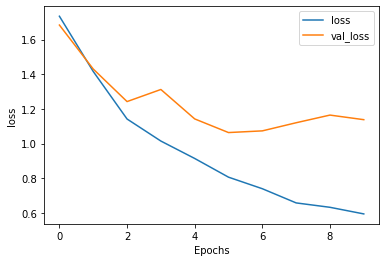

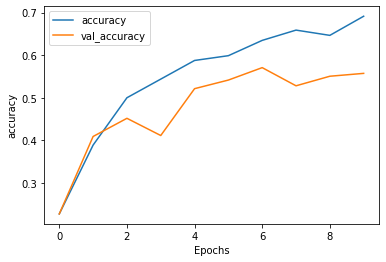

In [32]:
# code is taken from:
# https://github.com/https-deeplearning-ai/tensorflow-1-public

def plot_learning_curves(history, parameter):
    """ 
    Plot learning curves from 'history' object.

    Parameters:
        history (History object): result of the `fit` method execution
        parameter (str): parameter to explore: 'accuracy', 'loss', etc.

    >>> history = model.fit(...)
    >>> plot_learning_curves(history, "loss")
    >>> plot_learning_curves(history, "accuracy")
    >>> plot_learning_curves(history, "mse")
    """

    plt.plot(history.history[parameter])
    plt.plot(history.history['val_'+parameter])
    plt.xlabel("Epochs")
    plt.ylabel(parameter)
    plt.legend([parameter, 'val_'+parameter])
    plt.show()


plot_learning_curves(history, "loss")
plot_learning_curves(history, "accuracy")
# plot_learning_curves(history, "mse")

<h2><a id="Evaluate">6. Evaluate the model</a></h2>

Official documentation  - https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate

In [27]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 12ms/step - loss: 26.0000


26.0

<h2><a id="Save">7. Save and load the model</a></h2>

- Official documentation for `save` method - https://www.tensorflow.org/api_docs/python/tf/keras/Model#save
- Official documentation for `load_model` function - https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model

In [28]:
model_path = 'data/model.h5'
model.save(model_path)
model = tf.keras.models.load_model(model_path)

In [29]:
# save using current date and time in filename
import time
current_time = time.strftime("%Y_%m_%d-%H_%M_%S")  # 2022_02_01-14_05_32
model_path = f'data/model_{current_time}.h5'
model.save(model_path)